# Emission Measure

In [119]:
import os
import sys
import glob
import copy

import numpy as np
from scipy.interpolate import splev
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from sunpy.map import Map
import astropy.units as u
from astropy.visualization import ImageNormalize,SqrtStretch,AsinhStretch
from astropy.coordinates import SkyCoord
import distributed

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.analysis import DistributedAIACollection,DistributedAIACube
from synthesizAR.analysis.dem import EMCube

sys.path.append('../scripts/')
from dem import HannahKontarModel
from formatting import get_figsize,heating_palette

import warnings
warnings.filterwarnings('ignore',category=UserWarning,)

%matplotlib inline

In [2]:
cluster = distributed.LocalCluster(n_workers=64,threads_per_worker=1)
client = distributed.Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:38069 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 64 Memory: 270.38 GB


In [99]:
client.shutdown()

In [98]:
cluster.close()

First, read in the model and observational data. For now, we'll just take a time-average. It may be better to time-average in chunks though still not completely sure about that...

In [3]:
channels = [94,131,171,193,211,335]
read_template = '/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/cutouts/aia_lev1.5_201102*_{}_cutout.fits'

In [4]:
cube = DistributedAIACollection(*[DistributedAIACube.from_files(read_template.format(c)) for c in channels])

Next, set up the temperature bins.

In [5]:
temperature_bin_edges = 10.**np.arange(5.5,7.5,0.1) * u.K
temperature_bin_centers = (temperature_bin_edges[1:] + temperature_bin_edges[:-1])/2.

And calculate the instrument responses.

In [6]:
aia = InstrumentSDOAIA([0,1]*u.s,None)

In [7]:
responses = [splev(temperature_bin_centers.value, c['temperature_response_spline']) for c in aia.channels]

Next, we'll compute the emission measure distributions.

In [15]:
maps = [cube[c].average() for c in channels]

In [16]:
maps = [Map(m.data / m.meta['exptime'], m.meta) for m in maps]

In [19]:
hk_model = HannahKontarModel(maps, temperature_bin_edges, responses,
                             dem_path='/storage-home/w/wtb2/codes/demreg/idl/')

In [20]:
em = hk_model.fit(percent_error=0.2)

IDL 8.7.0 (linux x86_64 m64).
(c) 2018, Harris Geospatial Solutions, Inc.

Licensed for use by: Rice University (Main) via idl.lic.rice.edu:7070
License: 401801:****-****-****-AE5F
A new version is available: IDL 8.7.1
https://harrisgeospatial.flexnetoperations.com
 
% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
% SSW_PATH: Number of paths changed from 95 to 111
% Compiled module: HISSW_PROCEDURE.
% Compiled module: DN2DEM_POS_NB.
% Compiled module: GET_EDGES.
% Compiled module: EDGE_PRODUCTS.
% Compiled module: INTERPOL.
% Compiled module: DEMMAP_POS.
% Compiled module: DEM_INV_GSVDCSQ.
% Compiled module: DEM_INV_REG_PARAMETER_MAP.
% Program caused arithmetic error: Floating divide by 0
% Program caused arithmetic error: Floating illegal operand

SSW  setup will include: <gen 

/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/synthesizAR-0.1.dev820-py3.6.egg/synthesizAR/analysis/dem.py:59: SunpyDeprecationWarning: Deprecated in favor of MapSequence.
  super().__init__(map_list)
/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/sunpy-1.0.dev9846-py3.6-linux-x86_64.egg/sunpy/util/decorators.py:104: SunpyDeprecationWarning: Deprecated in favor of MapSequence. MapSequence has the same functionality as MapCube.
  return func(*args, **kwargs)


In [121]:
tmpcube_meta = copy.deepcopy(em[0].meta)
del tmpcube_meta['keycomments']
tmpcube = EMCube(u.Quantity(em.as_array(), tmpcube_meta['bunit']), tmpcube_meta, temperature_bin_edges, )
tmpcube.save('/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/dem/emcube_time_averaged.h5')

/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/synthesizAR-0.1.dev820-py3.6.egg/synthesizAR/analysis/dem.py:59: SunpyDeprecationWarning: Deprecated in favor of MapSequence.
  super().__init__(map_list)
/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/sunpy-1.0.dev9846-py3.6-linux-x86_64.egg/sunpy/util/decorators.py:104: SunpyDeprecationWarning: Deprecated in favor of MapSequence. MapSequence has the same functionality as MapCube.
  return func(*args, **kwargs)


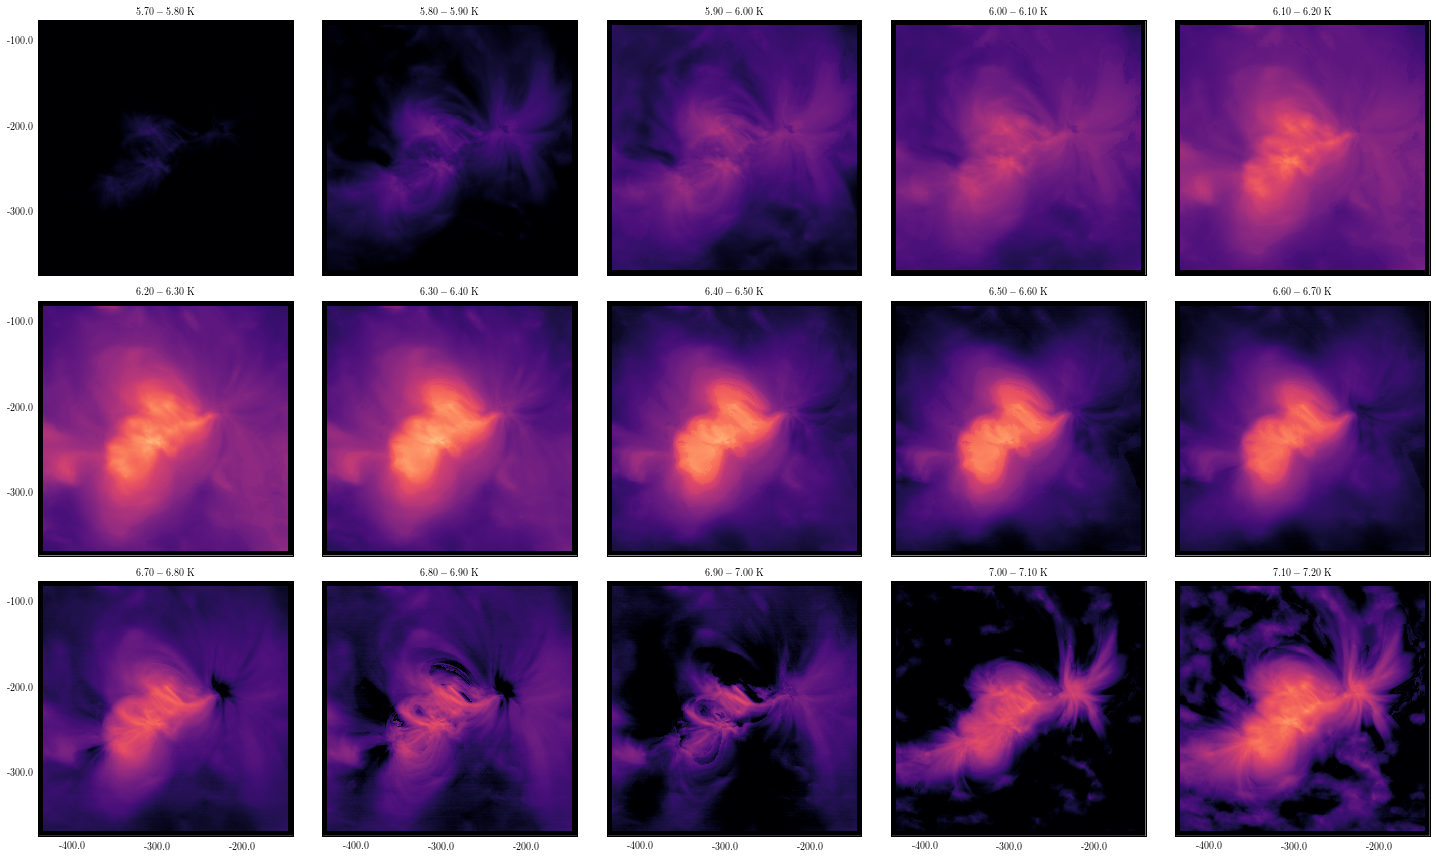

In [22]:
fig = plt.figure(figsize=(25,15))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
for i,j in enumerate(np.arange(0,len(em),1)[2:-2]):
    m = em[j]
    ax = fig.add_subplot(3,5,i+1,projection=m)
    m.plot(annotate=False,title=False,axes=ax,norm=matplotlib.colors.SymLogNorm(1,vmin=1e25,vmax=1e28))
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_ticks_visible(False)
    lat.set_ticks_visible(False)
    if i%5 != 0:
        lat.set_ticklabel_visible(False)
    if i < 10:
        lon.set_ticklabel_visible(False)
    ax.set_title(f'${np.log10(m.meta["temp_a"]):.2f}-{np.log10(m.meta["temp_b"]):.2f}$ K')